# Problem 1: Predicting Number of Attacks Next Month

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")


In [10]:
# Load the dataset
df = pd.read_csv("model1_dataset.csv")

prob1_dataset = df

In [11]:
# One hot encoding the model column as it is an object dt which the model cannot read
prob1_dataset = pd.get_dummies(prob1_dataset, columns=['model'])


In [12]:
# Dropping all null values
prob1_dataset = prob1_dataset.dropna()

## Training the model

Base model no hyperparameters

RMSE: 5.38
R²: -0.2021


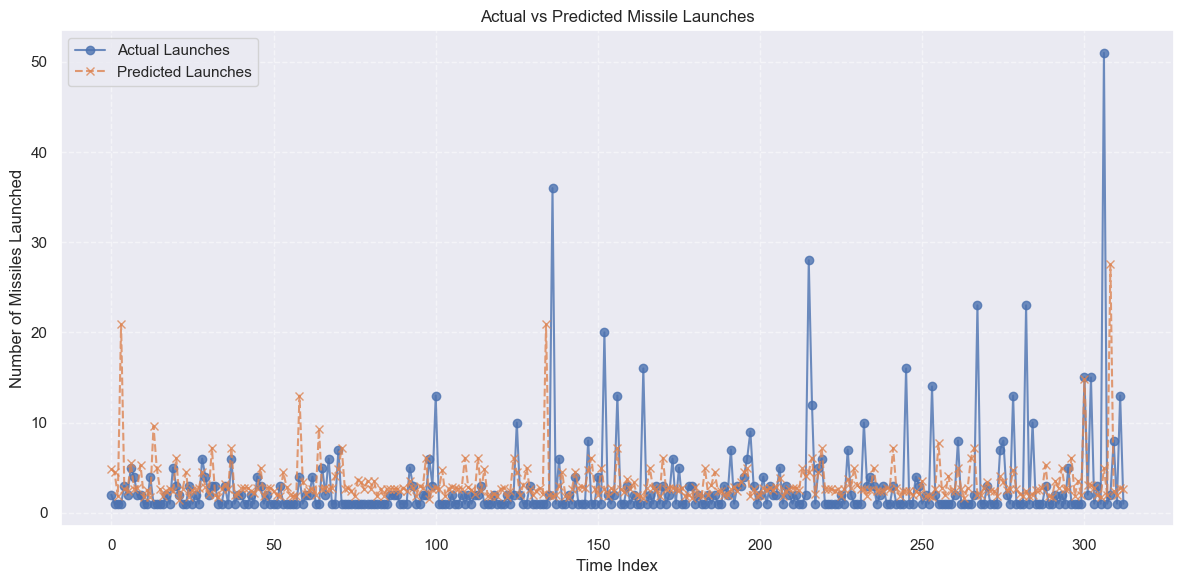

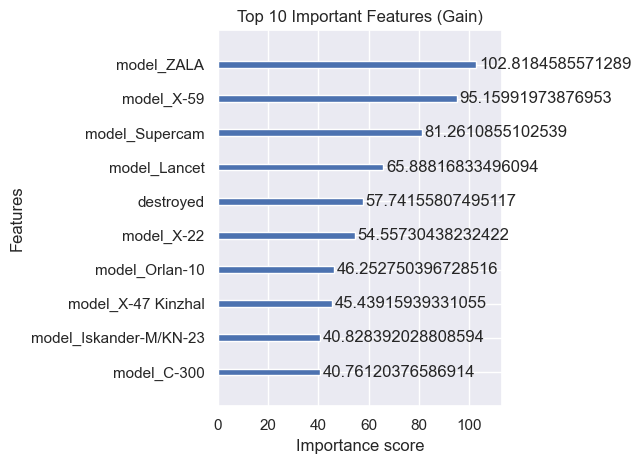

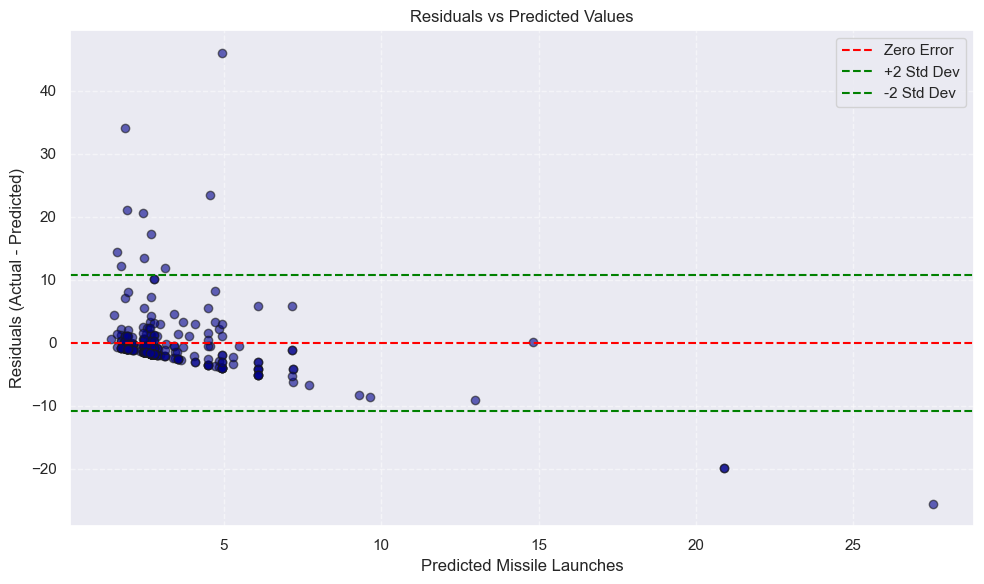

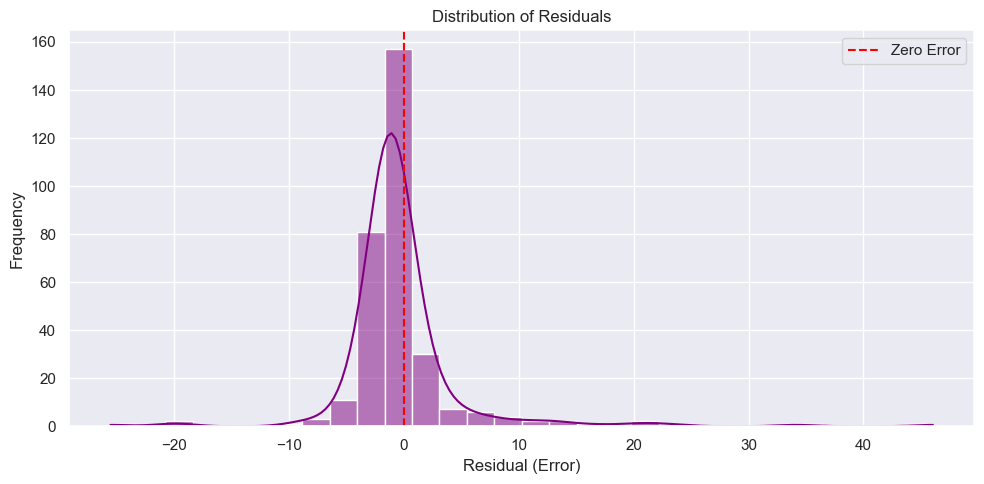

Residual Plot RMSE: 5.38


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = prob1_dataset.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = prob1_dataset['launched_next_month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

import seaborn as sns

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Launches', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred, label='Predicted Launches', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Missile Launches')
plt.xlabel('Time Index')
plt.ylabel('Number of Missiles Launched')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Feature importance plot
plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features (Gain)")
plt.tight_layout()
plt.show()

# Residuals Plot (for base model prediction)
residuals = y_test.values - y_pred
std_residuals = np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='darkblue', alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.axhline(y=std_residuals * 2, color='green', linestyle='--', label='+2 Std Dev')
plt.axhline(y=-std_residuals * 2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Missile Launches')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print RMSE again
print(f"Residual Plot RMSE: {rmse:.2f}")




### Second model using some hyperparameters 
    Which led to a much lower RMSE and a better accuracy R2 score but still not great accuracy.
    I concluded the dataset was too small and inconsistent as each fold could only have so much data in it, 
    due to small data pool leaving very little learnt from each training set. and a lack of pattern recognition by the model.

[I 2025-06-17 17:53:50,600] A new study created in memory with name: no-name-49506ca9-81c0-46dd-9971-848e0175d916


[I 2025-06-17 17:53:52,350] Trial 0 finished with value: 8.10351689709106 and parameters: {'n_estimators': 260, 'max_depth': 15, 'learning_rate': 0.04434621620283651, 'subsample': 0.8808169223587817, 'colsample_bytree': 0.9549929955855643, 'reg_alpha': 2.3328625967346484, 'reg_lambda': 0.054052289544411214}. Best is trial 0 with value: 8.10351689709106.
[I 2025-06-17 17:53:55,069] Trial 1 finished with value: 7.355589558723226 and parameters: {'n_estimators': 554, 'max_depth': 12, 'learning_rate': 0.05191592444038004, 'subsample': 0.8014652995630482, 'colsample_bytree': 0.7418590326472483, 'reg_alpha': 1.0969014557461565, 'reg_lambda': 3.3969839164631854}. Best is trial 1 with value: 7.355589558723226.
[I 2025-06-17 17:53:55,569] Trial 2 finished with value: 7.901568837936028 and parameters: {'n_estimators': 168, 'max_depth': 6, 'learning_rate': 0.26846000607076165, 'subsample': 0.5208453416971894, 'colsample_bytree': 0.8711305125430975, 'reg_alpha': 3.9565680797782954, 'reg_lambda': 3

Best parameters:
{'n_estimators': 135, 'max_depth': 4, 'learning_rate': 0.012273869723594932, 'subsample': 0.5024749149409258, 'colsample_bytree': 0.7604780048419099, 'reg_alpha': 2.631396586162497, 'reg_lambda': 2.910739212784338}

Final RMSE: 9.74
Final R²: -0.1515


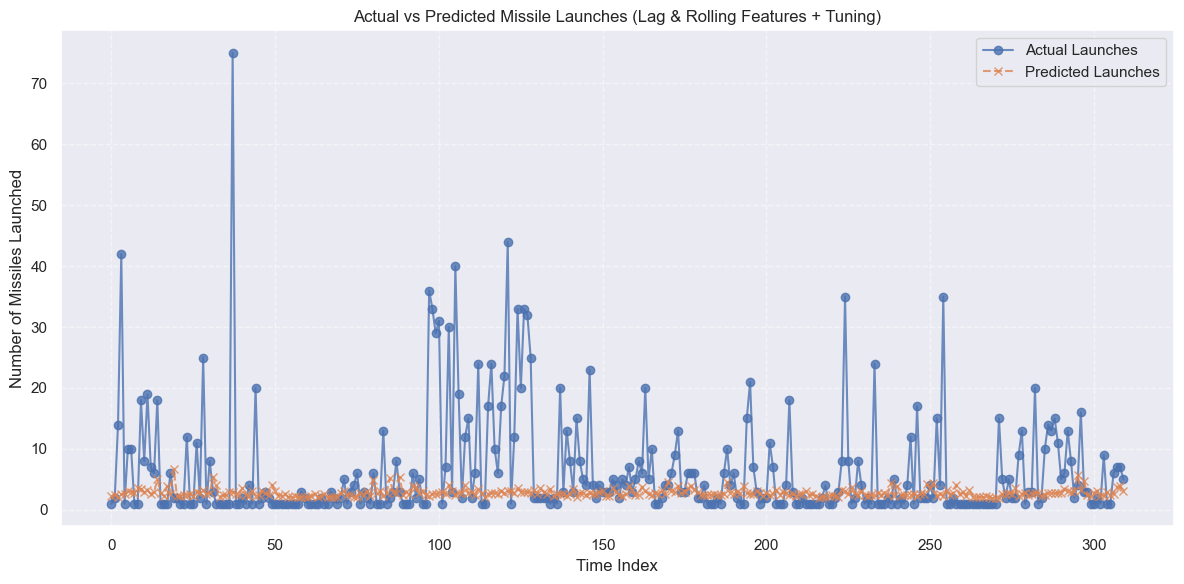

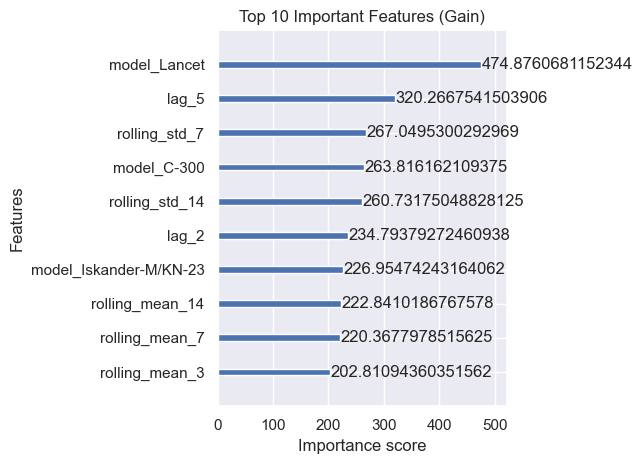

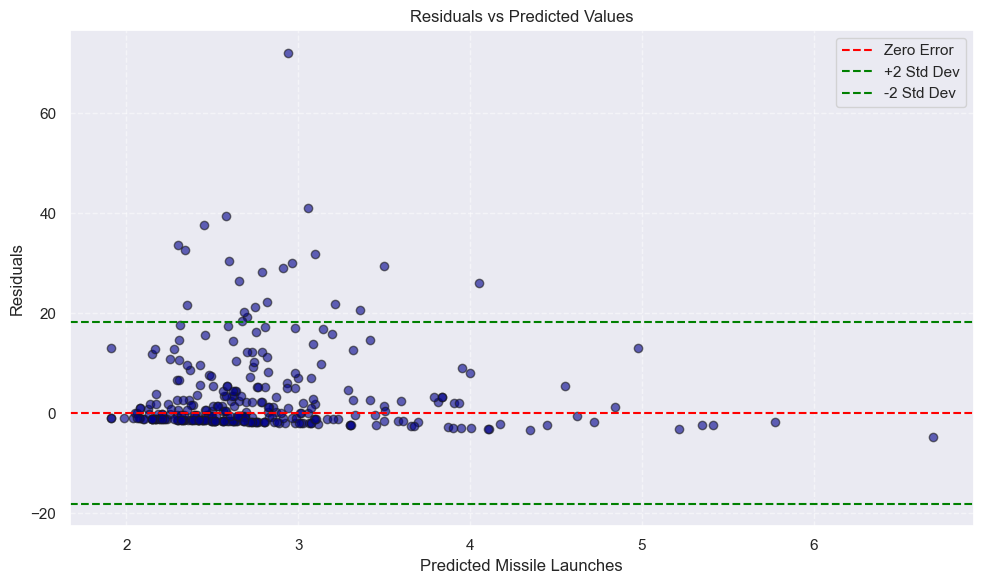

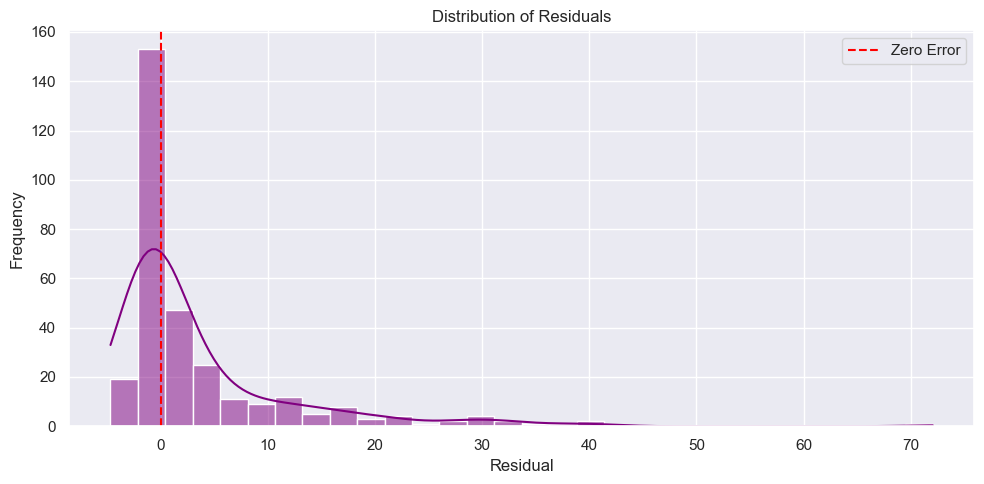

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from xgboost import XGBRegressor, plot_importance

# Base dataset copy
df = prob1_dataset.copy()

# Function to generate lag and rolling features
def create_features(data):
    df_feat = data.copy()
    # Existing lags
    df_feat['lag_1'] = df_feat['launched_next_month'].shift(1)
    df_feat['lag_2'] = df_feat['launched_next_month'].shift(2)
    df_feat['lag_3'] = df_feat['launched_next_month'].shift(3)
    # New lags
    for lag in [4, 5, 6]:
        df_feat[f'lag_{lag}'] = df_feat['launched_next_month'].shift(lag)
    # Rolling features
    df_feat['rolling_mean_3'] = df_feat['launched_next_month'].shift(1).rolling(window=3).mean()
    df_feat['rolling_std_3'] = df_feat['launched_next_month'].shift(1).rolling(window=3).std()
    df_feat['rolling_mean_7'] = df_feat['launched_next_month'].shift(1).rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['launched_next_month'].shift(1).rolling(window=7).std()
    df_feat['rolling_mean_14'] = df_feat['launched_next_month'].shift(1).rolling(window=14).mean()
    df_feat['rolling_std_14'] = df_feat['launched_next_month'].shift(1).rolling(window=14).std()
    return df_feat

# Apply feature creation
df = create_features(df)
df.dropna(inplace=True)  # Drop rows with NaNs from lagging and rolling

# Define features and target
X = df.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = df['launched_next_month']

# Optuna objective with TimeSeriesSplit inside,
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    
    for train_idx, valid_idx in tscv.split(X):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        model = XGBRegressor(**params)
        model.fit(X_train_cv, y_train_cv, verbose=False)
        
        preds = model.predict(X_valid_cv)
        rmse = np.sqrt(mean_squared_error(y_valid_cv, preds))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

print("Best parameters:")
print(study.best_params)

# Final train/test split (no shuffle for time order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train final model on best params, no early stopping
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train, verbose=True)

# Predict & evaluate on test set
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nFinal RMSE: {rmse:.2f}")
print(f"Final R²: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Launches', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred, label='Predicted Launches', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Missile Launches (Lag & Rolling Features + Tuning)')
plt.xlabel('Time Index')
plt.ylabel('Number of Missiles Launched')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Feature importance plot
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features (Gain)")
plt.tight_layout()
plt.show()

# Residuals analysis
residuals = y_test.values - y_pred
std_residuals = np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='darkblue', alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.axhline(std_residuals * 2, color='green', linestyle='--', label='+2 Std Dev')
plt.axhline(-std_residuals * 2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Missile Launches')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuals distribution
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


## Re-training with same pipeline using CatBoost

[I 2025-06-17 17:28:17,417] A new study created in memory with name: no-name-a9c44765-cfc9-49a7-b108-e28312f0bf91
[I 2025-06-17 17:28:33,121] Trial 0 finished with value: 6.75054928613671 and parameters: {'iterations': 427, 'depth': 10, 'learning_rate': 0.09103384769045167, 'l2_leaf_reg': 0.0224862339579038, 'bagging_temperature': 0.6582564856350788}. Best is trial 0 with value: 6.75054928613671.
[I 2025-06-17 17:28:34,489] Trial 1 finished with value: 6.692988916509206 and parameters: {'iterations': 351, 'depth': 5, 'learning_rate': 0.026249821837457832, 'l2_leaf_reg': 0.3366136899098455, 'bagging_temperature': 0.8249406079164148}. Best is trial 1 with value: 6.692988916509206.
[I 2025-06-17 17:28:48,730] Trial 2 finished with value: 6.828666935742365 and parameters: {'iterations': 399, 'depth': 10, 'learning_rate': 0.17862348721229715, 'l2_leaf_reg': 0.1347613439498341, 'bagging_temperature': 0.683949023200197}. Best is trial 1 with value: 6.692988916509206.
[I 2025-06-17 17:28:59,06

Best parameters: {'iterations': 233, 'depth': 8, 'learning_rate': 0.05466618115473441, 'l2_leaf_reg': 1.331605212475011, 'bagging_temperature': 0.22903328562724978}
0:	learn: 5.4482429	test: 9.8270223	best: 9.8270223 (0)	total: 2.95ms	remaining: 684ms
1:	learn: 5.4146461	test: 9.8272420	best: 9.8270223 (0)	total: 5.35ms	remaining: 618ms
2:	learn: 5.3932217	test: 9.8320839	best: 9.8270223 (0)	total: 7.8ms	remaining: 598ms
3:	learn: 5.3560649	test: 9.8256876	best: 9.8256876 (3)	total: 9.86ms	remaining: 565ms
4:	learn: 5.3315734	test: 9.8211532	best: 9.8211532 (4)	total: 12ms	remaining: 549ms
5:	learn: 5.2971522	test: 9.8208750	best: 9.8208750 (5)	total: 14.4ms	remaining: 545ms
6:	learn: 5.2663434	test: 9.8179877	best: 9.8179877 (6)	total: 16.6ms	remaining: 535ms
7:	learn: 5.2246604	test: 9.8109347	best: 9.8109347 (7)	total: 18.8ms	remaining: 529ms
8:	learn: 5.1984559	test: 9.8157352	best: 9.8109347 (7)	total: 21.3ms	remaining: 529ms
9:	learn: 5.1596805	test: 9.8089791	best: 9.8089791 (9)

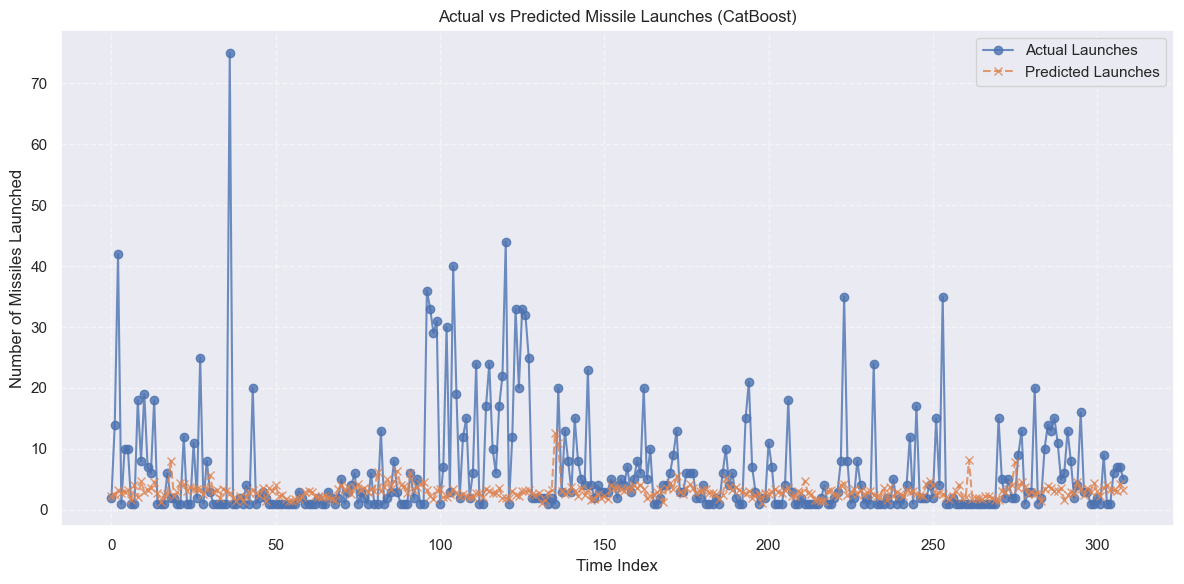

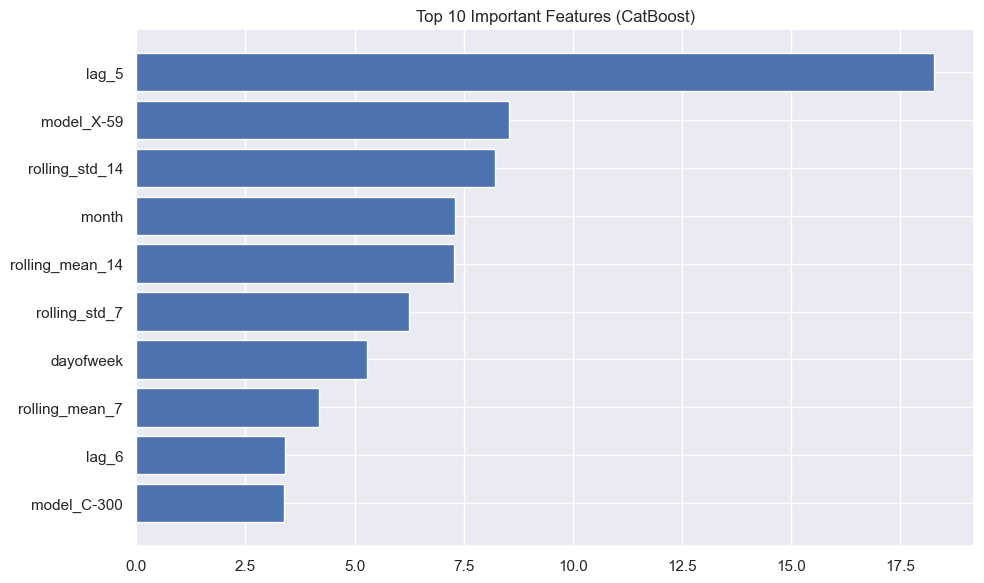

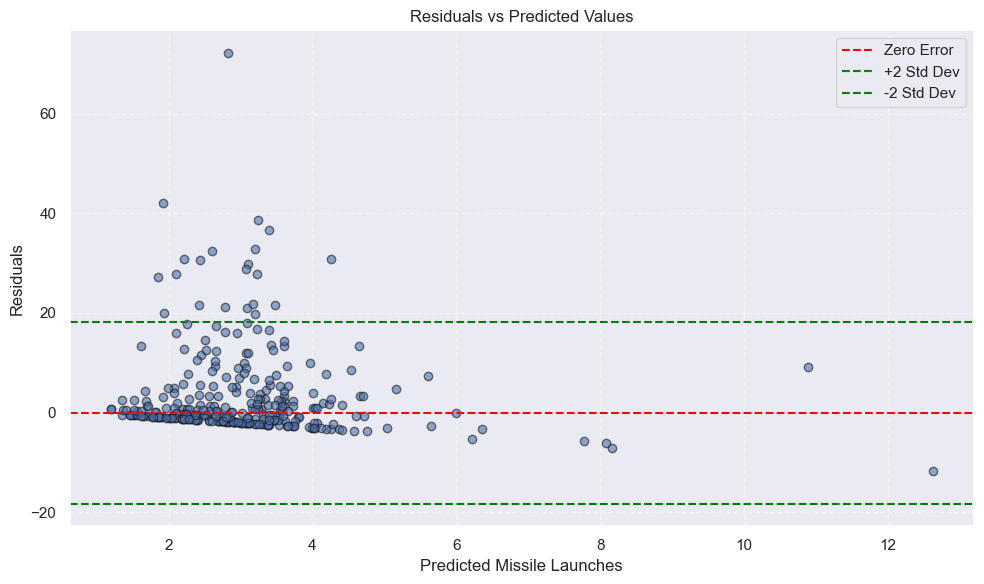

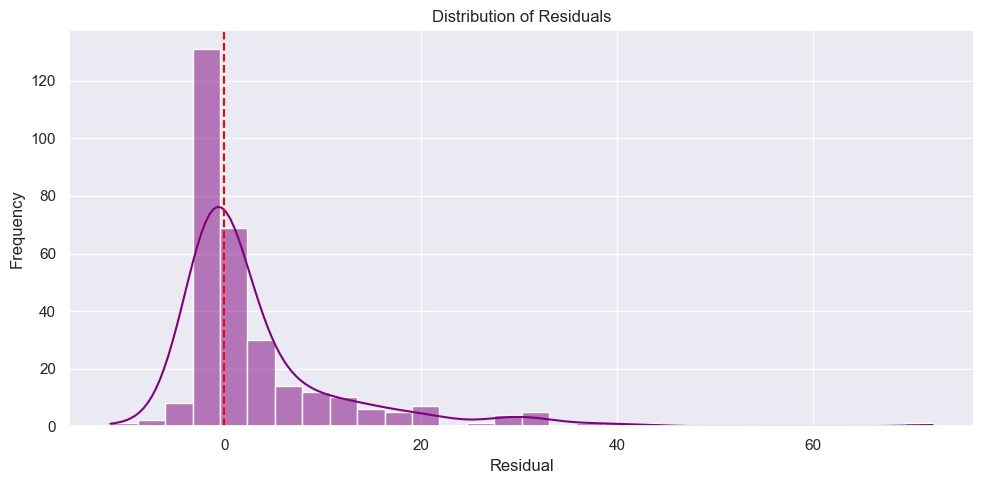

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from catboost import CatBoostRegressor, Pool

# Copy dataset
df = prob1_dataset.copy()

# Feature creation function (lags + rolling)
def create_features(data):
    df_feat = data.copy()
    df_feat['lag_1'] = df_feat['launched_next_month'].shift(1)
    df_feat['lag_2'] = df_feat['launched_next_month'].shift(2)
    df_feat['lag_3'] = df_feat['launched_next_month'].shift(3)
    for lag in [4, 5, 6]:
        df_feat[f'lag_{lag}'] = df_feat['launched_next_month'].shift(lag)
    df_feat['rolling_mean_3'] = df_feat['launched_next_month'].shift(1).rolling(window=3).mean()
    df_feat['rolling_std_3'] = df_feat['launched_next_month'].shift(1).rolling(window=3).std()
    df_feat['rolling_mean_7'] = df_feat['launched_next_month'].shift(1).rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['launched_next_month'].shift(1).rolling(window=7).std()
    df_feat['rolling_mean_14'] = df_feat['launched_next_month'].shift(1).rolling(window=14).mean()
    df_feat['rolling_std_14'] = df_feat['launched_next_month'].shift(1).rolling(window=14).std()
    return df_feat

df = create_features(df)
df.dropna(inplace=True)

X = df.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = df['launched_next_month']

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_seed": 42,
        "verbose": False
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, valid_idx in tscv.split(X):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        train_pool = Pool(X_train_cv, y_train_cv)
        valid_pool = Pool(X_valid_cv, y_valid_cv)

        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=valid_pool)

        preds = model.predict(X_valid_cv)
        rmse = np.sqrt(mean_squared_error(y_valid_cv, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

print("Best parameters:", study.best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

final_model = CatBoostRegressor(**study.best_params, verbose=True)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nFinal RMSE: {rmse:.2f}")
print(f"Final R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Launches', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred, label='Predicted Launches', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Missile Launches (CatBoost)')
plt.xlabel('Time Index')
plt.ylabel('Number of Missiles Launched')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Feature importance
feature_importances = final_model.get_feature_importance()
features = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx][:10][::-1], feature_importances[sorted_idx][:10][::-1])
plt.title("Top 10 Important Features (CatBoost)")
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test.values - y_pred
std_residuals = np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.axhline(std_residuals * 2, color='green', linestyle='--', label='+2 Std Dev')
plt.axhline(-std_residuals * 2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Missile Launches')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Trying Linear Regression

[I 2025-06-17 18:15:47,410] A new study created in memory with name: no-name-ffa22de5-1149-4c00-afe5-8edc11a14756
C:\Users\sonny bell\AppData\Local\Temp\ipykernel_33052\1643219432.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-6, 1e-1),
[I 2025-06-17 18:15:47,424] Trial 0 finished with value: 2397030246.939655 and parameters: {'max_iter': 2872, 'alpha': 2.1381759621955707e-05, 'learning_rate': 'adaptive', 'eta0': 0.014077000925490614, 'penalty': 'elasticnet', 'l1_ratio': 0.4052482039564229}. Best is trial 0 with value: 2397030246.939655.
C:\Users\sonny bell\AppData\Local\Temp\ipykernel_33052\1643219432.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

Best hyperparameters found:
{'max_iter': 2530, 'alpha': 0.00010101907250703209, 'learning_rate': 'constant', 'eta0': 0.00014025593850821845, 'penalty': 'l1'}

Final SGDRegressor RMSE: 4.91
Final SGDRegressor R²: -0.0005


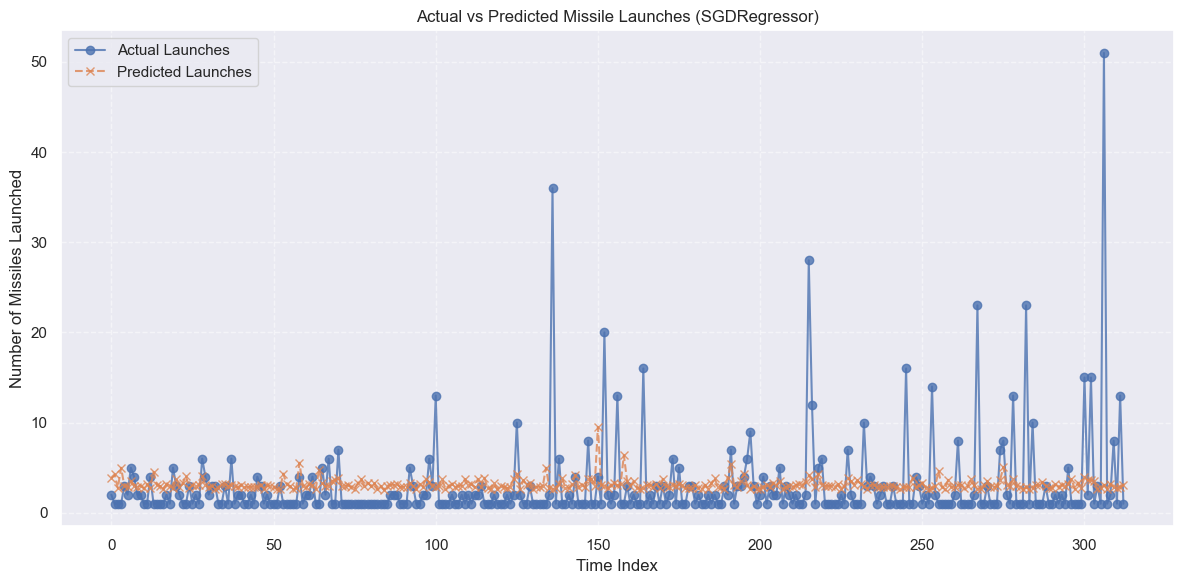

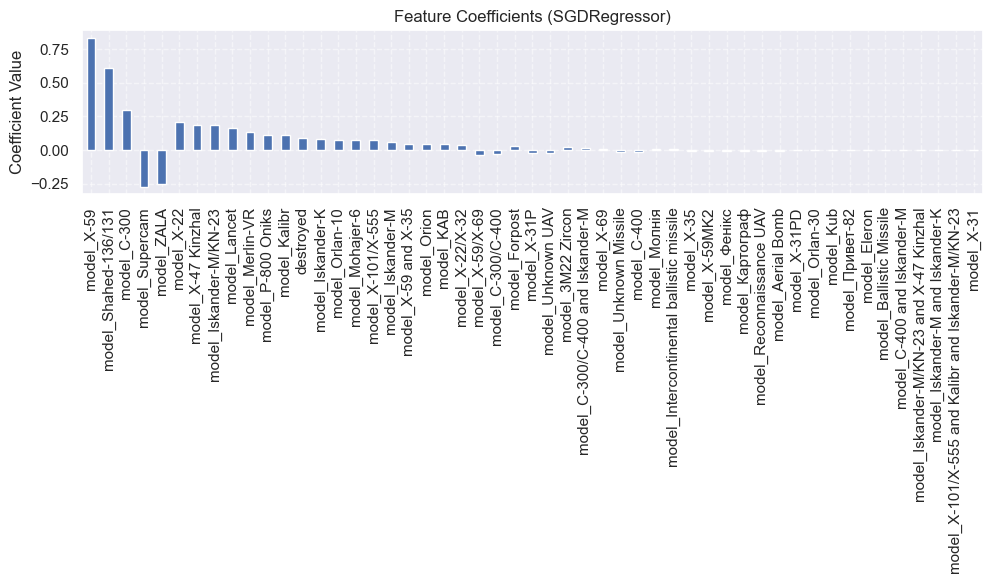

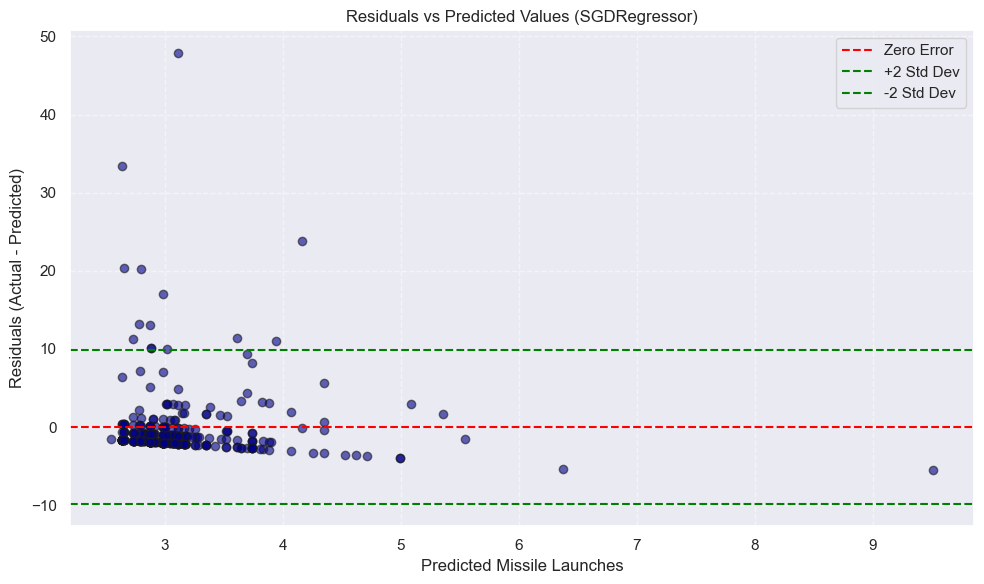

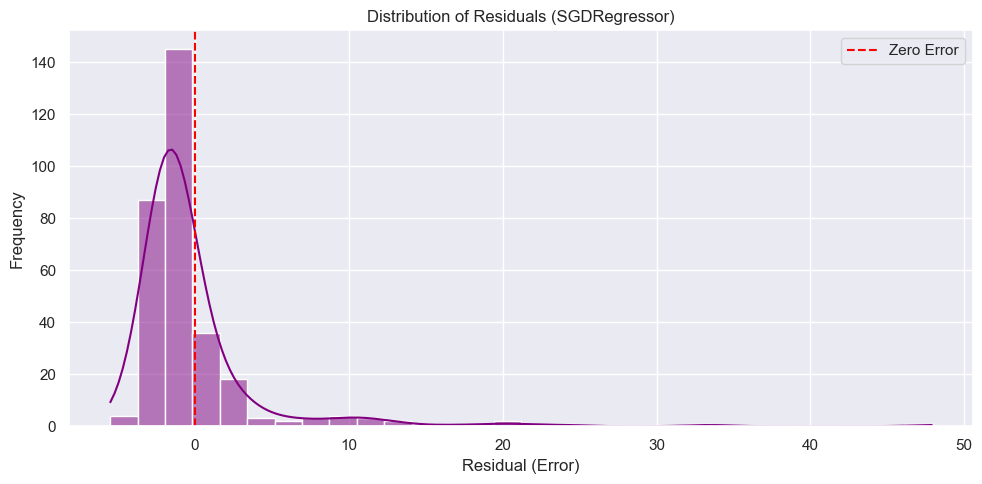

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data (same as your base)
X = prob1_dataset.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = prob1_dataset['launched_next_month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optuna objective function for tuning SGDRegressor
def objective(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'alpha': trial.suggest_loguniform('alpha', 1e-6, 1e-1),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-4, 1e-1, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0) if trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']) == 'elasticnet' else 0.0,
        'random_state': 42
    }
    
    # Fix l1_ratio param only if penalty=='elasticnet', else 0
    if params['penalty'] != 'elasticnet':
        params['l1_ratio'] = 0.0
    
    model = SGDRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# Run Optuna study to minimize RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print("Best hyperparameters found:")
print(study.best_params)

# Train final SGDRegressor with best params
best_params = study.best_params
# Ensure l1_ratio is set correctly (required by SGDRegressor API)
if best_params['penalty'] != 'elasticnet':
    best_params['l1_ratio'] = 0.0

final_model = SGDRegressor(**best_params)
final_model.fit(X_train, y_train)

# Predict & evaluate on test set
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nFinal SGDRegressor RMSE: {rmse:.2f}")
print(f"Final SGDRegressor R²: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Launches', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred, label='Predicted Launches', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Missile Launches (SGDRegressor)')
plt.xlabel('Time Index')
plt.ylabel('Number of Missiles Launched')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Feature coefficients plot (sorted by absolute magnitude)
coef = pd.Series(final_model.coef_, index=X.columns)
coef_sorted = coef.abs().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
coef[coef_sorted].plot(kind='bar')
plt.title('Feature Coefficients (SGDRegressor)')
plt.ylabel('Coefficient Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuals Plot
residuals = y_test.values - y_pred
std_residuals = np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='darkblue', alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.axhline(std_residuals * 2, color='green', linestyle='--', label='+2 Std Dev')
plt.axhline(-std_residuals * 2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Residuals vs Predicted Values (SGDRegressor)')
plt.xlabel('Predicted Missile Launches')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Residuals (SGDRegressor)')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


## Random Forest

Random Forest RMSE: 9.99
Random Forest R²: -0.2197


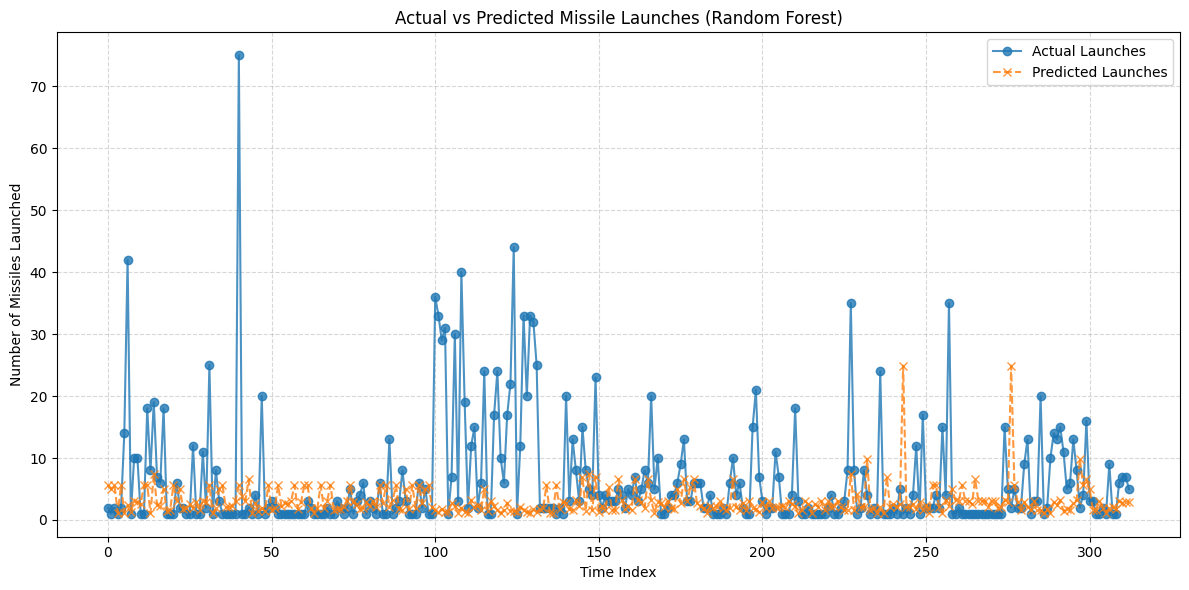

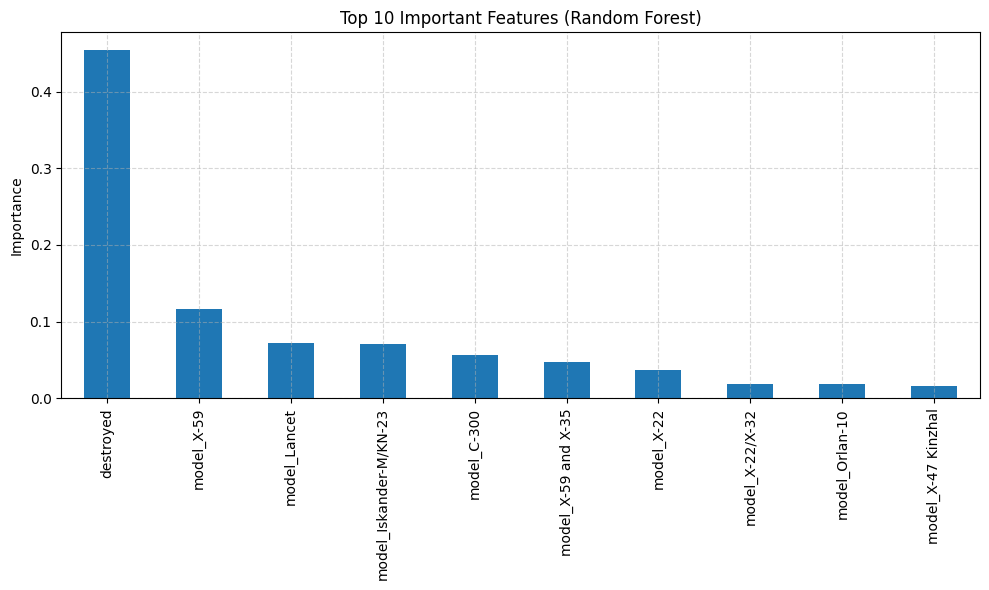

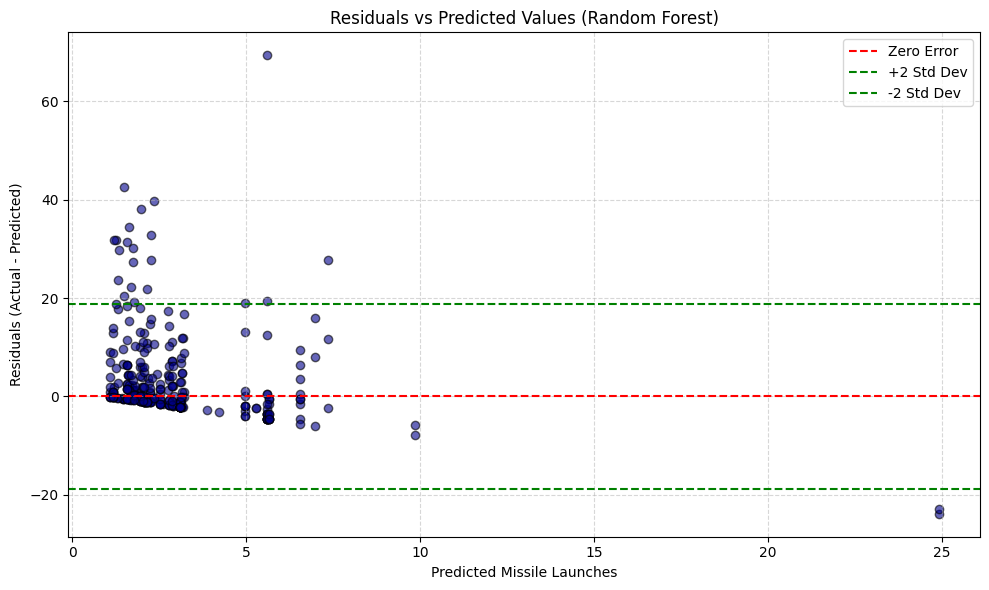

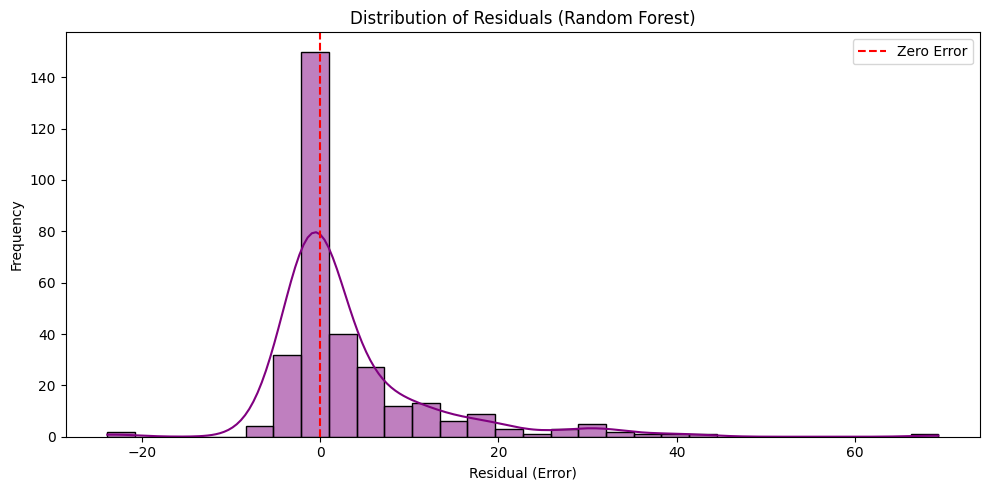

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = prob1_dataset.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = prob1_dataset['launched_next_month']

# Remove rows where target is NaN
mask = y.notna()
X = X[mask]
y = y[mask]

# Encode categorical features (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split (no shuffle for time series order)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, shuffle=False
)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R²: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Launches', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred, label='Predicted Launches', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Missile Launches (Random Forest)')
plt.xlabel('Time Index')
plt.ylabel('Number of Missiles Launched')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Feature importance plot
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X_encoded.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_importance.head(10).plot(kind='bar')
plt.title('Top 10 Important Features (Random Forest)')
plt.ylabel('Importance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test.values - y_pred
std_residuals = np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='darkblue', alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.axhline(std_residuals * 2, color='green', linestyle='--', label='+2 Std Dev')
plt.axhline(-std_residuals * 2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Residuals vs Predicted Values (Random Forest)')
plt.xlabel('Predicted Missile Launches')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuals distribution
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Residuals (Random Forest)')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()
